In [9]:

import numpy as np
import tools._init_paths
import models
import torch
import torch.nn.functional as F
from PIL import Image

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
color_map = [(128, 64,128),
             (244, 35,232),
             ( 70, 70, 70),
             (102,102,156),
             (190,153,153),
             (153,153,153),
             (250,170, 30),
             (220,220,  0),
             (107,142, 35),
             (152,251,152),
             ( 70,130,180),
             (220, 20, 60),
             (255,  0,  0),
             (  0,  0,142),
             (  0,  0, 70),
             (  0, 60,100),
             (  0, 80,100),
             (  0,  0,230),
             (119, 11, 32)]

In [11]:
def input_transform(image):
    image = image.astype(np.float32)[:, :, ::-1]
    image = image / 255.0
    image -= mean
    image /= std
    return image

def load_pretrained(model, pretrained):
    pretrained_dict = torch.load(pretrained, map_location='cpu')
    if 'state_dict' in pretrained_dict:
        pretrained_dict = pretrained_dict['state_dict']
    model_dict = model.state_dict()
    pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if (k[6:] in model_dict and v.shape == model_dict[k[6:]].shape)}
    msg = 'Loaded {} parameters!'.format(len(pretrained_dict))
    print('Attention!!!')
    print(msg)
    print('Over!!!')
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict, strict = False)
    
    return model

pid_model = PIDNet(m=2, n=3, num_classes=19, planes=64, ppm_planes=96, head_planes=128, augment=True)
model = load_pretrained(pid_model, 'pretrained_models/custom_model.pt').cuda()
model.eval()

Attention!!!
Loaded 479 parameters!
Over!!!


PIDNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [12]:
import glob,cv2,os
images_list = glob.glob('./samples/*.jpg')
with torch.no_grad():
      for img_path in images_list:
            img_name = img_path.split("\\")[-1]
            img = cv2.imread(os.path.join(os.getcwd(),'samples', img_name),
                                    cv2.IMREAD_COLOR)
            sv_img = np.zeros_like(img).astype(np.uint8)
            img = input_transform(img)
            img = img.transpose((2, 0, 1)).copy()
            img = torch.from_numpy(img).unsqueeze(0).cuda()
            pred = model(img)
            pred = F.interpolate(pred[0], size=img.size()[-2:], 
                                    mode='bilinear', align_corners=True)
            pred = torch.argmax(pred, dim=1).squeeze(0).cpu().numpy()

            for i, color in enumerate(color_map):
                  for j in range(3):
                        sv_img[:,:,j][pred==i] = color_map[i][j]
            sv_img = Image.fromarray(sv_img)
            
            if not os.path.exists('backend_output'):
                  os.mkdir('backend_output')
            sv_img.save('backend_output/'+img_name)

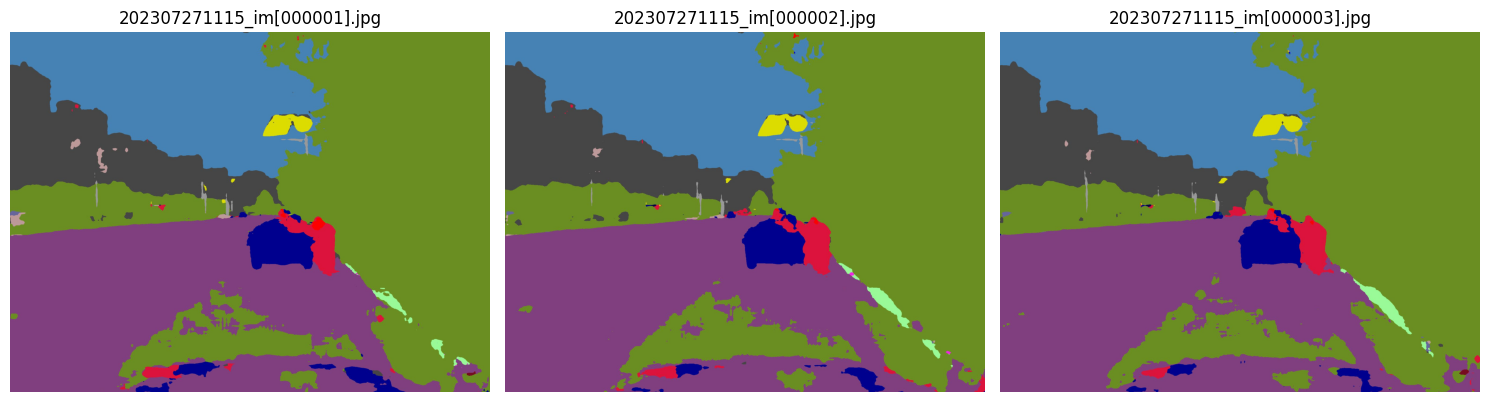

In [15]:
from PIL import Image
import matplotlib.pyplot as plt
import glob,os
labels_list = glob.glob('./backend_output/*.jpg')
# Open the image file
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Iterate over each file path to display the image and its name
for ax, file_path in zip(axs, labels_list[:3]):
    image = Image.open(file_path)
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(os.path.basename(file_path))

plt.tight_layout()
plt.show()